In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import datasets, linear_model, metrics
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.python.keras.layers as tfl
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from tensorflow.keras import regularizers
tf.keras.backend.set_floatx('float64')
from tensorflow.python.keras.callbacks import LambdaCallback
import tensorflow.python.keras.backend as K
import time

with open("dataa", "rb") as input_file:
   df = pickle.load(input_file)
df['CH2']=[np.nan]*len(df)
for i in range(len(df)):
    if df['CH2_SHELA'].iloc[i]!=-99 :
        if df['CH2_SPIES'].iloc[i]!=-99 :
            df['CH2'].iloc[i]=(df['CH2_SPIES'].iloc[i]+df['CH2_SHELA'].iloc[i])/2
        else :
            df['CH2'].iloc[i]=df['CH2_SHELA'].iloc[i]
    elif df['CH2_SPIES'].iloc[i]!=-99 :
        df['CH2'].iloc[i]=df['CH2_SPIES'].iloc[i]
df['CH1']=[np.nan]*len(df)
for i in range(len(df)):
    if df['CH1_SHELA'].iloc[i]!=-99 :
        if df['CH1_SPIES'].iloc[i]!=-99 :
            df['CH1'].iloc[i]=(df['CH1_SPIES'].iloc[i]+df['CH1_SHELA'].iloc[i])/2
        else :
            df['CH1'].iloc[i]=df['CH1_SHELA'].iloc[i]
    elif df['CH1_SPIES'].iloc[i]!=-99 :
        df['CH1'].iloc[i]=df['CH1_SPIES'].iloc[i]
    else :
        df['CH1'].iloc[i]=np.nan
dff=df[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2','REDSHIFT','REDSHIFT_ERR','ZWARNING']].dropna()
dff[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2','REDSHIFT']]=dff[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2','REDSHIFT']].replace(-99,np.nan).dropna()
dff=dff.where(dff['REDSHIFT_ERR']<dff['REDSHIFT']*0.1).dropna()
dff=dff.sample(frac=1)
X_data,y_data=dff[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2']],dff['REDSHIFT']

def Model2(l2=1e-2):
    model = tf.keras.Sequential([
        tfl.Dense(25,'relu',input_shape=(12,),kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(12,'relu',kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(1,'linear',kernel_regularizer=regularizers.l2(l2)),
        ])
    return model
def return_his(history,n='n'):
    if n=='n':
        N=len(history)
        hisloss=np.sum([history[i].history['loss'] for i in range(N)],axis=0)/N
        hisval=np.sum([history[i].history['val_loss'] for i in range(N)],axis=0)/N
    else :
        hisloss=history[n].history['loss']
        hisval=history[n].history['val_loss']
    return (np.array(hisloss),np.array(hisval))
def score(ys_data,pred):
    return K.mean(K.abs((pred-ys_data)/(1+ys_data)))

inscaler = MinMaxScaler((-1,1))
Xs_data  = inscaler.fit_transform(X_data)

N=int(len(Xs_data)/4)
for l2 in [0]:
    print('\n')
    for i in range(1):
        print(l2)
        history4=[]
        dz_val,dz_train=[],[]
        start=time.time()
        for i in range(4):
                Xs_train,y_train=list(Xs_data.copy()),list(y_data.copy())
                del Xs_train[i*N:i*N+N]
                del y_train[i*N:i*N+N]
                Xs_val,y_val=Xs_data[i*N:i*N+N],y_data[i*N:i*N+N]
                ouscaler= MinMaxScaler()
                ys_train= ouscaler.fit_transform(np.array(y_train).reshape(-1,1))
                ys_val  = ouscaler.transform(np.array(y_val).reshape(-1,1))
                Xs_train,Xs_val,ys_train,ys_val,y_val,y_train=np.array(Xs_train),np.array(Xs_val),np.array(ys_train),np.array(ys_val),np.array(y_val),np.array(y_train)
                model4 = Model2(l2)
                optimizer=tf.keras.optimizers.Adam(0.0001)
                model4.compile(optimizer=optimizer,loss=score)
                h=model4.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=1000,verbose=0)
                pred_train=ouscaler.inverse_transform(model4.predict(Xs_train)).reshape(len(y_train))
                pred_val=ouscaler.inverse_transform(model4.predict(Xs_val)).reshape(len(y_val))
                dz_val.append(np.array((pred_val-y_val)/(1+y_val)))
                dz_train.append(np.array((pred_train-y_train)/(1+y_train)))
                #print('std train:',np.std(dz_train[-1]),'\nmean train:',np.mean(dz_train[-1]))
                print('std val:',np.std(dz_val[-1]),'\nmean val:',np.mean(dz_val[-1]))
                history4.append(h)
        stop=time.time()
        print(f"Training time: {stop - start}s")
        trainstd,trainmean,valstd,valmean=np.mean([np.std(dz_train[i]) for i in range(4)]),np.mean(np.abs([np.mean(dz_train[i]) for i in range(4)])),np.mean([np.std(dz_val[i]) for i in range(4)]),np.mean(np.abs([np.mean(dz_val[i]) for i in range(4)]))
        print('train : \nstd :',trainstd,'\nmean :',trainmean)
        print('val   : \nstd :',valstd,'\nmean :',valmean)
        N=len(history4)
        trainloss=np.sum([history4[i].history['loss'] for i in range(N)],axis=0)[-1]/N
        valloss=np.sum([history4[i].history['val_loss'] for i in range(N)],axis=0)[-1]/N
        print('trainloss-',trainloss,'valloss-',valloss)
        #pickle.dump(return_his(history4), open(str(l2)+'_11_10_2.pkl', 'wb'))
#model4.save('model_1_8_10/my_model')



0
std val: 0.14827585171829702 
mean val: -0.0003001677635203147
std val: 0.18260739246155533 
mean val: 0.0018259254916440878
std val: 0.15671708446906887 
mean val: -0.019257805463099284
std val: 0.1609308879505206 
mean val: -0.008820735511898554
Training time: 143.84759092330933s
train : 
std : 0.1449067296633562 
mean : 0.008979711034396248
val   : 
std : 0.16213280414986045 
mean : 0.00755115855754056
trainloss- 0.031013774155112715 valloss- 0.03471036179703516


<IPython.core.display.Javascript object>


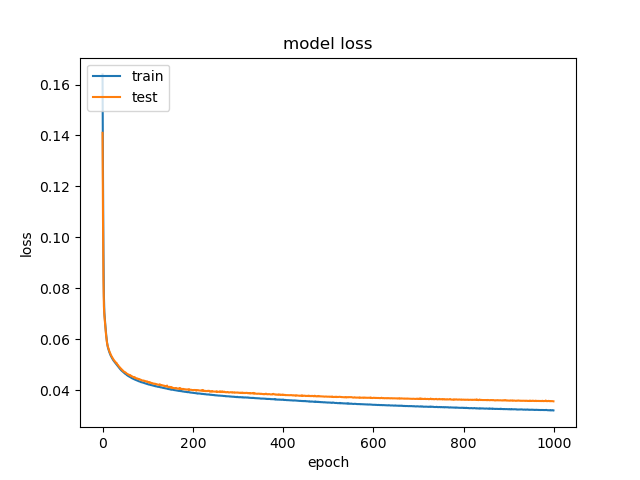

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
def plot_his(history,n='n'):
    if n=='n':
        N=len(history)
        hisloss=np.sum([history[i].history['loss'] for i in range(N)],axis=0)/N
        hisval=np.sum([history[i].history['val_loss'] for i in range(N)],axis=0)/N
    else :
        hisloss=history[n].history['loss']
        hisval=history[n].history['val_loss']
    plt.figure()
    plt.plot(hisloss)
    plt.plot(hisval)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plot_his(history4)

0
Training time: 144.92421078681946s
train : 
std : 0.1468410476093284 
mean : 0.006264263236406209
val   : 
std : 0.1605895900403962 
mean : 0.0063892633992645555
trainloss- 0.032024682263508734 valloss- 0.03559568980952057
0
Training time: 142.55643844604492s
train : 
std : 0.1439367133237126 
mean : 0.007436608042382645
val   : 
std : 0.15891143682070077 
mean : 0.008710437478199433
trainloss- 0.031245558526322777 valloss- 0.03540410726461693
0
Training time: 142.86933183670044s
train : 
std : 0.1448362347758658 
mean : 0.008303235519838949
val   : 
std : 0.15551025191583898 
mean : 0.006368429327716807
trainloss- 0.031120763583248664 valloss- 0.033750977622668064

In [15]:
print(model4.layers[0].get_weights())

[array([[ 3.90696197e-01,  1.89976917e-01,  5.35949902e-01,
        -2.55694950e-01, -1.15906853e-01, -1.00216619e-01,
        -3.86358265e-01,  1.45451573e-01, -3.63263976e-01,
        -1.04441961e-01, -3.80157714e-01,  2.06150363e-01,
         3.15965898e-01, -8.68835448e-02,  3.13235310e-01,
        -1.19469085e-01,  9.31283008e-02,  1.59208231e-01,
        -1.41668305e-01,  3.68787901e-01, -4.41325456e-01,
        -2.42538727e-01,  7.60037011e-02,  2.60165519e-01,
        -3.68265347e-01],
       [-1.62004505e-03, -2.08005424e-01,  1.73078122e-01,
         2.19912946e-03, -5.22394592e-01,  1.02563198e-01,
        -2.57719435e-02, -8.54324723e-02,  4.51180933e-02,
         3.25916010e-01, -4.05726205e-02,  9.92705699e-03,
        -1.53453733e-02,  1.36073301e-01, -3.87096193e-01,
        -1.75072428e-01, -3.88642634e-01,  1.78393406e-01,
         1.09893877e-01, -5.87331049e-01, -9.05720070e-02,
         2.94627151e-01, -5.55756610e-03,  3.32176889e-01,
         3.23636125e-01],
   